# Automatic Image Caption Generation using Deep Neural Networks

# Table of Contents

- 1.0 Introduction
- 2.0 Import libraries
- 3.0 Loading the dataset
- 4.0 Data Pre-Processing
- 5.0 Data Generation
- 6.0 Modelling
- 7.0 Analyzing the model
- 8.0 Evaluation metrics
- 9.0 Optimization process
- 10.0 Conclusions
- 11.0 References

# 1.0 Introduction 
# Image caption Generation

Vision is an ever-present topic in our lives, however, hardly we are aware of the complex process
needed to produce an image in our brain, for instance when we woke up and open our eyes, we do
not think of how the iris controls the amount of light that the pupils let in, or how the photoreceptors
turn that light into electrical signals that are transported through the optical nerve.[1] Neither we
think about how those signals are processed in the visual cortex, to then involving more regions of
the brain that produces shapes, objects and concepts

Computer vision has many applications among them we can find object detection, image
classification, object tracking and automatic image captioning that is a challenging problem that
aims to convert images into English sentences. In image caption generation not only the objects in
an image need to be identified but also the model must find their relationship and then generate text
that describe those relationships and objects. Image caption generation has many application fields
such as: human computer interaction, medial image captioning and automatic medical prescription,
quality control in industry and has been notable used in the design of assistants for visual impaired
people.[6]

Image caption generation is a challenging task, the main idea is to automatically generate an image
description in a natural language, for this project the language is English. An image caption can
be a short description of the objects on the image or a more complex interpretation of the objects
and their relationships.



## What is Image Captioning ?

Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.
CNNs + RNNs (LSTMs)

To perform Image Captioning we will require two deep learning models combined into one for the training purpose
CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction
LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word
For a more illustrative explanation of this architecture check the Modelling section for a picture representation

# 2.0 Import libraries needed for the project

### Option to work with gpu on MacOS

In [1]:
# physical_devices = tensorflow.config.list_physical_devices('GPU')
# tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)

In [58]:
## local libraries
# install libreries in case of being needed
# !pip install nltk
# !pip install pandas
# !pip install numpy
#!pip install matplotlib
#!pip install seaborn
import json
import pickle
import numpy as np
import pandas as pd
import os
import tensorflow as tf
tf.config.run_functions_eagerly(True) # model error
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

from keras.optimizers import adam_v2
# here we download the callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

#plot models
from tensorflow.keras.utils import plot_model


# 3.0 Loading the dataset

we first download the Flickr-8k dataset to the local machine, we get it fom kaggel

https://www.kaggle.com/datasets/adityajn105/flickr8k

now we are going to set the path to the images folder and we are going to download the 
captions

In [4]:
path = '../0_datasets/Flickr-8k/archive/Images'

Now we are going to check 3 images captions, each image has 5 captions

In [5]:
# convert the captions in a dataframe
data = pd.read_csv('../0_datasets/Flickr-8k/archive/captions.txt')

data.head(15)

image  \
0   1000268201_693b08cb0e.jpg   
1   1000268201_693b08cb0e.jpg   
2   1000268201_693b08cb0e.jpg   
3   1000268201_693b08cb0e.jpg   
4   1000268201_693b08cb0e.jpg   
5   1001773457_577c3a7d70.jpg   
6   1001773457_577c3a7d70.jpg   
7   1001773457_577c3a7d70.jpg   
8   1001773457_577c3a7d70.jpg   
9   1001773457_577c3a7d70.jpg   
10  1002674143_1b742ab4b8.jpg   
11  1002674143_1b742ab4b8.jpg   
12  1002674143_1b742ab4b8.jpg   
13  1002674143_1b742ab4b8.jpg   
14  1002674143_1b742ab4b8.jpg   

                                              caption  
0   A child in a pink dress is climbing up a set o...  
1               A girl going into a wooden building .  
2    A little girl climbing into a wooden playhouse .  
3   A little girl climbing the stairs to her playh...  
4   A little girl in a pink dress going into a woo...  
5          A black dog and a spotted dog are fighting  
6   A black dog and a tri-colored dog playing with...  
7   A black dog and a white dog with brown spots a...  
8   Two dogs of different breeds looking at each o...  
9     Two dogs on pavement moving toward each other .  
10  A little girl covered in paint sits in front o...  
11  A little girl is sitting in front of a large p...  
12  A small girl in the grass plays with fingerpai...  
13  There is a girl with pigtails sitting in front...  
14  Young girl with pigtails painting outside in t...

## 3.1 Data presentation

### 3.1.1 Helper functions to show the images

In [6]:
def normalize_img(image):
    """normalize the values of the image

    Args:
        image (array): array of pixels of an image between 0 -255

    Returns:
        array: normalize array 
    """
    return tf.cast(image, tf.float32) / 255


def readImage(path, img_size=224):
    """Load the images of the dataset
    
    load the images, uses rgb color,
    each image is loaded as an array of 3 dimension (224, 224, 3)
    then the image is convert into an array
    the array is normalized to handle values between zero and 1, this will help us
    with the training process

    Args:
        path (str): path to the images folder
        img_size (int,): the size of the image. Defaults to 224.

    Returns:
        return an array of (224, 224, 3) with values between 0-1
    """
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = normalize_img(img)

    return img


def display_images(temp_df, num_img=15):
    """display the images and its captions
    create a grid to display n, n images

    Args:
        temp_df (_type_): _description_
    """
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(num_img):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = readImage(
            f"../0_datasets/Flickr-8k/archive/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")


### 15 Images are presented as example of the dataset

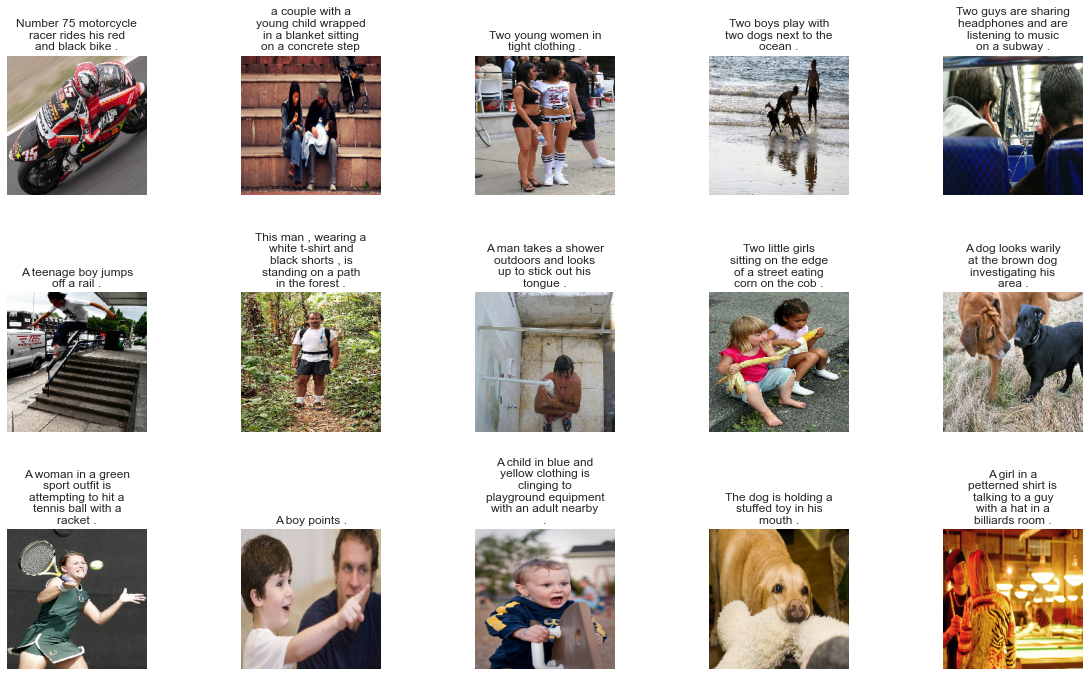

In [8]:
# from PIL import Image
# !pip install pillow
display_images(data.sample(15))

# 4.0 Data Preprocessing

## 4.1 Text preprocessing 

Caption Text Preprocessing Steps
Convert sentences into lowercase
Remove special characters and numbers present in the text
Remove extra spaces
Remove single characters
Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

In [91]:
def text_preprocessing(data):
    """pre process the caption text 
    lower the letters
    remove non-alphanumeric values
    remove multiple spaces and let only one space
    join the caption
    add a start and end of sequence symbols

    Args:
        data (dataframe): dataframe with the captions

    Returns:
        text: preprocessed text
    """
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(
        lambda x: x.replace("[^A-Za-z]" , ""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+", " "))
    data['caption'] = data['caption'].apply(lambda x: " ".join(
        [word for word in x.split() if len(word) > 1]))
    data['caption'] = "<start> " + data['caption'] + " <end>" #help the model to know where to start and stop the prediction
    return data


now we can see the effect of text preprocessing applied to 10 examples

In [10]:
data =  text_preprocessing(data)

captions = data['caption'].to_list()
captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

## 4.2 Tokenization and Encoded Representation

- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings


In [92]:
tokenizer = Tokenizer()
#now we pass all the captions
tokenizer.fit_on_texts(captions)
# find the lengeth of the vocabulary of the captions
vocab_size = len(tokenizer.word_index) + 1
# find the maximun lenght of an individual caption
max_length = max(len(caption.split()) for caption in captions)
print('vocabulary size: {0}'.format(vocab_size))
max_length
print('Max length of one captions: {0}'.format(max_length))


vocabulary size: 8483
Max length of one captions: 34


In [93]:
# now we make a list of the images
images = data['image'].unique().tolist()
nimages = len(images)
nimages

8091

## 4.3 Split Train, validation and test sets

we will use 80% for training, 10 % for validation and 10% for testing

In [94]:
# following the previous workflow for text preprocessing
import random
random.seed(123)
# instantiation of the keras.preprocessing.text tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

# now we are going to shuffle our data
random.shuffle(images)
images

# split the train, validation and test sets
split_index_train = round(0.8 * nimages)
split_index_test_val = round(0.1 * nimages)
test_images = images[ : split_index_test_val]
train_images = images[split_index_test_val : split_index_train]
val_images = images[split_index_train + split_index_test_val: ]

train = data[data['image'].isin(train_images)]
validation = data[data['image'].isin(val_images)]
test = data[data['image'].isin(test_images)]

train.reset_index(inplace=True, drop=True)
validation.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]


[2, 18, 315, 63, 195, 116, 1]

## 4.4 Image Feature Extraction

the image feature extraction will be done in 2 ways, the first one will be done directly from the original images in the flirk8 dataset, in the second the feature map will be extracted from an augmented image 

the images will be loaded with a size of 224 in both height and width and 3 channels, RGB

In [95]:
from tensorflow.keras.utils import image_dataset_from_directory

path_test = '../0_datasets/Flickr-8k/archive/'

train_dataset = image_dataset_from_directory(
    path_test,
    image_size=(224, 224),
    batch_size=1)


Found 8091 files belonging to 1 classes.


## 4.4.1 Data augmentation layer

the idea behind data augmentation is to give a richer feature map and to simulate the image taken by a visual impaired person

In [96]:
# now we are goint to try augmentation in this dataset 
import keras
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
        keras.layers.RandomContrast(0.25)
    ]
)


Data augmentation grid example

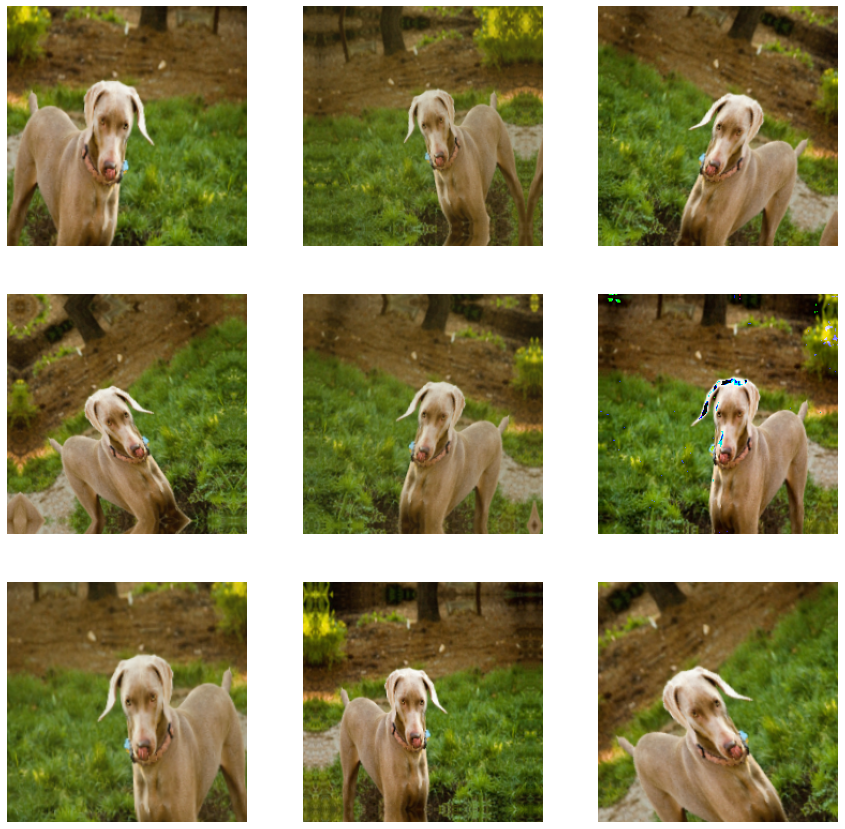

In [99]:
plt.figure(figsize=(15, 15))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


data augmentation single example

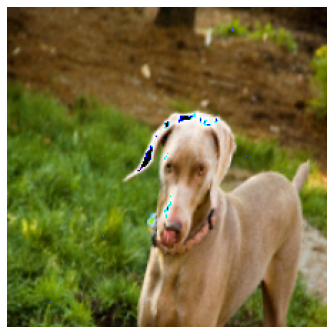

In [100]:
plt.figure(figsize=(20, 20))
for images, _ in train_dataset.take(1):
    for i in range(5, 9, 5):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## 4.4.2 Feature extraction CNN pretrained models

two pretrained model will be used in this project, VGG16 and ResNet50, we will take up to the fully conected layer, just before the softmax layer


## 4.4.2.1 VGG16

In [105]:
# feature extraction models

# model VGG16
model_vgg = VGG16(include_top=True,
    weights = 'imagenet',
    classes = 1000,
    classifier_activation = 'softmax')

model_vgg.trainable = False

# we use the convolutional base, this is just before the Dense layer
feature_extracted_vgg = Model(inputs=model_vgg.input,
                          outputs=model_vgg.layers[-2].output)


## 4.4.2.2 ResNet50

In [106]:
#feature map extraction pretrained model

# model ResNet50
model_resnet = ResNet50V2(include_top=True,
                   weights='imagenet',
                   classes=1000,
                   classifier_activation='softmax')

model_resnet.trainable = False

# we use the convolutional base, this is just before the Dense layer
feature_extracted_resnet = Model(inputs=model_resnet.input, outputs=model_resnet.layers[-2].output)


In [20]:
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [103]:
model_resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

## 4.4.3 Function to extract features from the dataset without data augmentation

In [121]:
# here we can select the CNN pretrained model to be used
# Feature extraction consists of using the representations learned by a previously
# trained model to extract highlevel features from images

def extract_featues(data_text=data, cnn='resnet50'):
    """extract image features

    Args:
        data (dataframe): dataframe with the images names
        cnn (string): it can be resnet50 or vgg16

    Returns:
        feature map: the feature map will depend on the use of the CNN chosen
        feature map shape VGG16 4096, shape ResNet50 2048
    """
    img_size = 224
    features = {}

    for image in tqdm(data_text['image'].unique().tolist()):
        img = load_img(os.path.join(path, image),
                    target_size=(img_size, img_size))
        # preprocess the image
        img = img_to_array(img)
        img = normalize_img(img)
        img = np.expand_dims(img, axis=0)
        # select the cnn
        if (cnn == 'resnet50'):
            feature = feature_extracted_resnet.predict(img, verbose=0)
            features[image] = feature
        elif(cnn == 'vgg16'):
            feature = feature_extracted_vgg.predict(img, verbose=0)
            features[image] = feature
    
    return features


## 4.4.4 Extract features with data augmentation on the whole dataset in one step

- first we rename the pretrained models as augmented



In [22]:
model_vgg_augmented = VGG16(include_top=True,
                            weights='imagenet',
                            classes=1000,
                            classifier_activation='softmax')


model_vgg_augmented.trainable = False

inputs = model_vgg_augmented.input
outputs = model_vgg_augmented.layers[-2].output

# we use the convolutional base, this is just before the Dense layer
feature_extracted_augmented_vgg = Model(inputs=inputs,
                                    outputs=outputs)


In [154]:
model_resnet_augmented = ResNet50V2(include_top=True,
                          weights='imagenet',
                          classes=1000,
                          classifier_activation='softmax')

model_resnet_augmented.trainable = False

inputs = model_resnet_augmented.input

outputs = model_resnet_augmented.layers[-2].output
#print(outputs)
# we use the convolutional base, this is just before the Dense layer
feature_extracted_augmented_resnet = Model(inputs=inputs,
                          outputs=outputs)


In [108]:
def extract_featues_augmentation(data_text=data, cnn='resnet50'):
    """extract image features with data augmentation, we generate 5 augmented images and select only one 
    of them, we are doing this to introduce more randomess to the process 

    Args:
        data (dataframe): dataframe with the captions and images ids
        cnn (string): it can be resnet50 or vgg16

    Returns:
        dic: returns a dict that maps the image ids to the feature map
            feature map shape VGG16 4096, shape ResNet50 2048
    """
    img_size = 224
    features = {}
    i = 0  # for testing
    for image in tqdm(data_text['image'].unique().tolist()):
        img = load_img(os.path.join(path, image),
                       target_size=(img_size, img_size))
        
        
        img = img_to_array(img)
        img = normalize_img(img)
        img = np.expand_dims(img, axis=0)
        
        features[image] = []

        for k in range(5, 9, 5):
            # apply data augmentation to the input image from the dataset
            aumented_data = data_augmentation(img)
            if(cnn == 'resnet50'):
                features_aumented_data = feature_extracted_augmented_resnet.predict(aumented_data, verbose=0)
            elif(cnn == 'vgg16'):
               features_aumented_data = feature_extracted_augmented_vgg.predict(aumented_data, verbose=0)
            features[image].append(features_aumented_data)
        

    return features

## 4.4.5 Extract features with data augmentation on each epoch

- this function will return just the feature map of an image, and this function will be use to 
generate data augmentation during training on each epoch



In [153]:
def extract_featues_augmentation_on_epoch(image, cnn='resnet50'):
    """extract image augmented features

    Args:
        image: the name of an image is passed

    Returns:
        image: return an augmented version of the image
    """
    img_size = 224
    
    img = load_img(os.path.join(path, image),
                    target_size=(img_size, img_size))
    # normalize the image
    img = img_to_array(img)
    img = normalize_img(img)
    img = np.expand_dims(img, axis=0)
    # pass as input to the feature extraction function a version augmented of the original image
    if(cnn == 'resnet50'):
        features_augmented = feature_extracted_augmented_resnet.predict(data_augmentation(img), verbose=0)
    elif(cnn == 'vgg16'):
        features_augmented = feature_extracted_augmented_vgg.predict(data_augmentation(img), verbose=0)
    
    return features_augmented[0]
   


## 4.4.6 Extract features from the whole dataset without augmentation 

In [127]:
# we want to apply data augmentation only to the train set
#features = extract_featues(data_text=data)
features = extract_featues(data_text=data, cnn='resnet50')


100%|██████████| 8091/8091 [31:57<00:00,  4.22it/s]


In [134]:
# verification of the feature map shape
len(features['1000268201_693b08cb0e.jpg'][0])


2048

## 4.4.7 Save features map without augmentation to disk and load them again

In [135]:
# np.save('../2_cnn_lstm/features/features.npy', features)
# data2=np.load('../2_cnn_lstm/features/features.npy', allow_pickle=True)
import os
path_features = '../2_cnn_lstm/features/'

In [136]:
# save features
pickle.dump(features, open(os.path.join(path_features, 'features_saved_resnet.pkl'), 'wb'))


In [137]:
# load features
with open(os.path.join(path_features, 'features_saved_resnet.pkl'), 'rb') as f:
    features_saved = pickle.load(f)


## 4.4.8 Extract features map with augmentation on the whole dataset

In [97]:
# extract features with data augmentation
features_augmented = extract_featues_augmentation(data_text=data)


100%|██████████| 8091/8091 [28:38<00:00,  4.71it/s]


## 4.4.9 Save features map augmented to disk and load them again

In [182]:
# np.save('../2_cnn_lstm/features/features_augmentation.npy', features_augmentation)
# data_aug = np.load(
#     '../2_cnn_lstm/features/features_augmentation.npy', allow_pickle=True)



In [98]:
# save features
pickle.dump(features_augmented, open(os.path.join(path_features, 'features_augmented_saved.pkl'), 'wb'))


In [29]:
# load features
with open(os.path.join(path_features, 'features_augmented_saved.pkl'), 'rb') as f:
    features_augmented_saved = pickle.load(f)


# 5.0 Data Generation¶
-  we cannot load the data into the main memory all at once, we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresponding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

## 5.1 Data loader for image without augmentation

In [138]:
class CustomDataGenerator(Sequence):
    """this class will be the data loader to the training function, we only use data augmentation during training
    the main objective of this class is to return 2 inputs X, and one target value Y

    """

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features, shuffle=True):
        """required arguments to instatiate the data generator class

        Args:
            df (dataframe): datafame with the image_id and the captions of each image
            X_col (string): col name of images_id
            y_col (string): col name of captions
            batch_size (int): batch size of the sample
            directory (string): path to the directory
            tokenizer (model): model with the tokenizer fitted on the vocabulary
            vocab_size (int): vocab size of the captions
            max_length (int): max length of a caption
            shuffle (bool, optional): if shuffle on each epoch. Defaults to True.
        """

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        # shuffle data on each epoch
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        # get the length of the batch
        return self.n // self.batch_size

    def __getitem__(self, index):
        # get the input data and target data of the batch
        batch = self.df.iloc[index *
                             self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        """get the feature map of an image, the sequence of words as sequence and pad to the max lenght of 
        the captions and the target word as categorical to be used in the LSTM

        Args:
            batch (df): the images_id and captions in the dataset for that batch

        Returns:
            numpy array: 3 numpy array with two inputs and one output
        """

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]
                                 == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical(
                        [out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y


## 5.2 Data loader for images with data augmentation 

In [150]:

class CustomDataGenerator_augmentation(Sequence):
    """this class will be the data loader to the training function, we only use data augmentation during training
    the main objective of this class is to return 2 inputs X, and one target value Y

    """
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, shuffle=True):
        """required arguments to instatiate the data generator class

        Args:
            df (dataframe): datafame with the image_id and the captions of each image
            X_col (string): col name of images_id
            y_col (string): col name of captions 
            batch_size (int): batch size of the sample
            directory (string): path to the directory
            tokenizer (model): model with the tokenizer fitted on the vocabulary
            vocab_size (int): vocab size of the captions
            max_length (int): max length of a caption
            shuffle (bool, optional): if shuffle on each epoch. Defaults to True.
        """

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        # shuffle data on each epoch
        return self.n // self.batch_size

    def __getitem__(self, index):
        # get the input data and target data of the batch
        batch = self.df.iloc[index *
                             self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        """get the feature map of an image, the sequence of words as sequence and pad to the max lenght of 
        the captions and the target word as categorical to be used in the LSTM

        Args:
            batch (df): the images_id and captions in the dataset for that batch

        Returns:
            numpy array: 3 numpy array with the inputs and output
        """

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            # now we will chenge each epoch calling the 
            feature = extract_featues_augmentation_on_epoch(image, cnn='resnet50')
            
            captions = batch.loc[batch[self.X_col]
                                == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]                
                    
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical(
                        [out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

# 6.0  Modelling
- The image embedding representations are concatenated with the first word of sentence < star> and passed to the LSTM network
- The LSTM network starts generating words after each input thus forming a sentence, when the token < end> is found the LSTM knows that it can stop

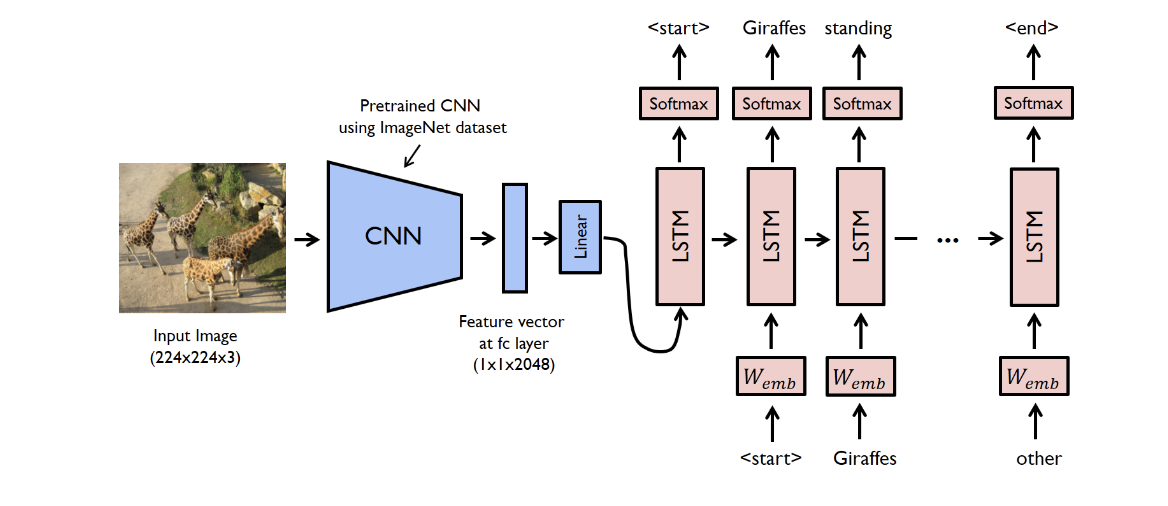

the following 3 code cells are an attempt to develop a custom evaluation metric to be used during training, among the metrics considered are, perplexity, Bleu1, the idea is to use tensorflow.keras.backend to carry out the calculations 

In [81]:
import tensorflow.keras.backend as K


In [78]:
def bleu_1_metric(y_predict, y_ground, weights=(1.0, 0, 0, 0)):
    return K.nltk.translate.bleu_score.corpus_bleu(y_predict, y_ground, weights=weights)

# bleu_1 = nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses, weights=(1.0, 0,0,0))

In [82]:
def perplexity(y_true, y_pred):
    """
    The perplexity metric. Why isn't this part of Keras yet?!
    https://stackoverflow.com/questions/41881308/how-to-calculate-perplexity-of-rnn-in-tensorflow
    https://github.com/keras-team/keras/issues/8267
    """
    cross_entropy = K.sparse_categorical_crossentropy(y_true, y_pred)
    perplexity = K.exp(cross_entropy)
    return perplexity


## 6.1 now we are going to use the functional API to build our model with the encoder and decoder

In [140]:
# inputs holds info about the type and shape of the info preprocessed, inputs are also called symbolic tensors
input1 = Input(shape=(2048,), name='image_features') #feature shape VGG16 4096, shape ResNet50 2048
input2 = Input(shape=(max_length,), name='captions_preprocessed') #captions that are padded with 0 up to the max caption length

img_features = Dense(256, activation='relu')(input1) #now we create a Dense layer with 256 neurones and pass the image features
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features) #now we reshape the image feature to 1, 256

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2) #now we create a embedding layer with input dimension = vocabulary size and output dimension = 256, 
# and pass the captions 
merged = concatenate([img_features_reshaped, sentence_features],axis=1) #now we pass the 2 tensors of size 256 and merge on axis 1
sentence_features = LSTM(256)(merged) #it has 256 units, by default it hast activation == tanh, recurrent_activation == sigmoid, recurrent_dropout == 0,
# unroll is False, use_bias is True,  this are requirements to use GPU acceleration

x = Dropout(0.5)(sentence_features) #now we apply dropout to the ouput of the LSTM layer, we use 0.5 dropout, this is in order of prevent overfitting, it is only
# applyed during training
x = add([x, img_features]) # now we add the output of the img_features dense network, this works as a residual connectios simmilar to those in the ResNet50
x = Dense(128, activation='relu')(x) #apply a rely activaction and use 128 units
x = Dropout(0.5)(x) #now we apply dropout to the ouput after the dense layer, we use 0.5 dropout
output = Dense(vocab_size, activation='softmax')(x) # output the most likely sequence of words.

caption_model = Model(inputs=[input1,input2], outputs=output) #instatiate the model with 2 inputs and one output
optimizer = adam_v2.Adam() #use Adam optimizer to avoid local minima in multidimensional space
caption_model.compile(loss='categorical_crossentropy',optimizer=optimizer) # compile the model

In [141]:
from tensorflow.keras.utils import plot_model
# from keras.utils import plot_model


## 6.1.1 plot and summary of the model

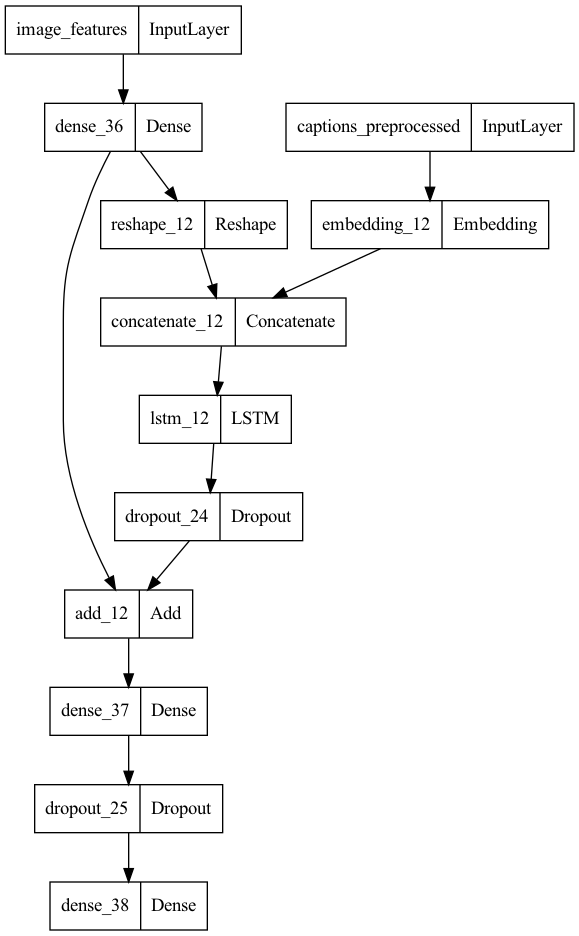

In [142]:
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz

plot_model(caption_model)


In [143]:
caption_model.summary()


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_features (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 dense_36 (Dense)               (None, 256)          524544      ['image_features[0][0]']         
                                                                                                  
 captions_preprocessed (InputLa  [(None, 34)]        0           []                               
 yer)                                                                                             
                                                                                                  
 reshape_12 (Reshape)           (None, 1, 256)       0           ['dense_36[0][0]']        

## 6.1.2 instantiate the data loader

In [144]:

train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features_saved)

validation_generator = CustomDataGenerator(df=validation,X_col='image',y_col='caption',batch_size=64,directory=path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features_saved)


train_augmented_generator = CustomDataGenerator_augmentation(df=train, X_col='image', y_col='caption', batch_size=64, directory=path,
                                                             tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length)

# extract_featues_augmentation(data_text=data)



## 6.1.3 Model callbacks to customize the behaviour of the model 

In [145]:
# we are going to save the best model during training,
# we will use the validation loss to select the best model
model_name = "model_10_aug_perplexity.h5"
checkpoint_path = '../2_cnn_lstm/model/'
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True, #save_weights_only=True,
                             verbose=1)

# if the model does not improve during 5 epochs
earlystopping = EarlyStopping(monitor='val_loss', 
                              min_delta=0, 
                              patience=5, 
                              verbose=1, 
                              restore_best_weights=True)

# reduce the learning rate when the model stop learning
# if the model does not improve during 3 epochs the learning rate is reduced
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00001)

# Let's enable visualization with tensorboard
tensorboard_callback = TensorBoard(log_dir="../2_cnn_lstm/logs/",
                                   histogram_freq=1,
                                   embeddings_freq=1)


# this is how to load the weights again
# Create a new model instance

# model = create_model()
# model.load_weights(checkpoint_path)

#  load all the model
# new_model = tf.keras.models.load_model('./model/model.h5')


## 6.1.4 Training the Model

when we call train the model fit(), we must select if we want to work
with augmented data or normal data.
the data augmented will be only the train part, so we use train_augmented_generator
and for both cases we will use validation data without augmentation

In [90]:
history = caption_model.fit(
    train_generator,
    epochs=10,   #they use 50 by default
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction, tensorboard_callback],
    verbose=1)


Epoch 1/10
  4/442 [..............................] - ETA: 29:15 - loss: 8.6934

KeyboardInterrupt: 

# 7.0 Analyzing the model
- Learning Curve (Loss Curve)


## 7.1 Training and validation loss

now we will plot the loss plot and analyze it

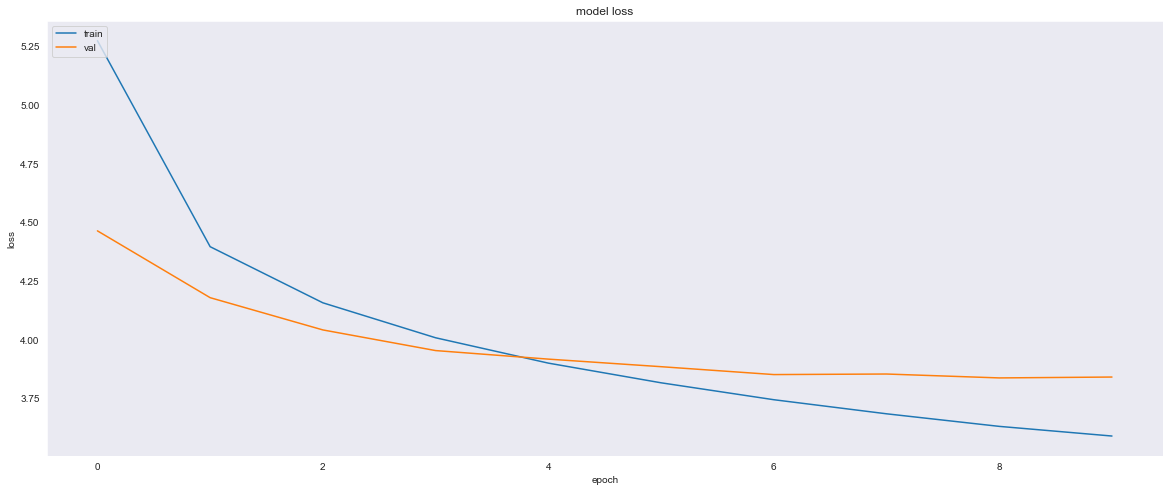

In [40]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## 7.2 Caption Generation in the test set

now we will define a couple of functions to generate the test set captions, first we need to generate words from the indexes,
and then we need to predict the caption


In [161]:
def idx_to_word(integer, tokenizer):
    """from index to words

    Args:
        integer (int): indexes used
        tokenizer (model): tokenizer trained on the captions

    Returns:
        word: string
    """

    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [162]:
def predict_caption(model, image, tokenizer, max_length, features):
    """predict the captions for an image given a tokenizer

    Args:
        model (int): model trained to predict captions
        image (str): image id
        tokenizer (model): tokenizer trained on the captions
        max_length (int): max length of the captions
        features: feature map

    Returns:
        word: string with captions generated for that image
    """
    feature = features[image]
    in_text = "<start>" # tag for generation process
    # now we iterate taking into account the longest captiion
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # sequence works as input shape
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature, sequence])
        y_pred = np.argmax(y_pred)
        # from index to words
        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break
        
        if word == 'end':
            in_text += " " + '<end>'
            break

        in_text += " " + word

    return in_text


## 7.3 Taking 15 Random Samples for Caption Prediction

In [63]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [61]:
for index, record in samples.iterrows():
    
    img = load_img(os.path.join(path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    # during inference we use the features_saved, those are the features without
    # augmentation in both cases when we work with and without augmentation
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features_saved)
    samples.loc[index,'caption'] = caption


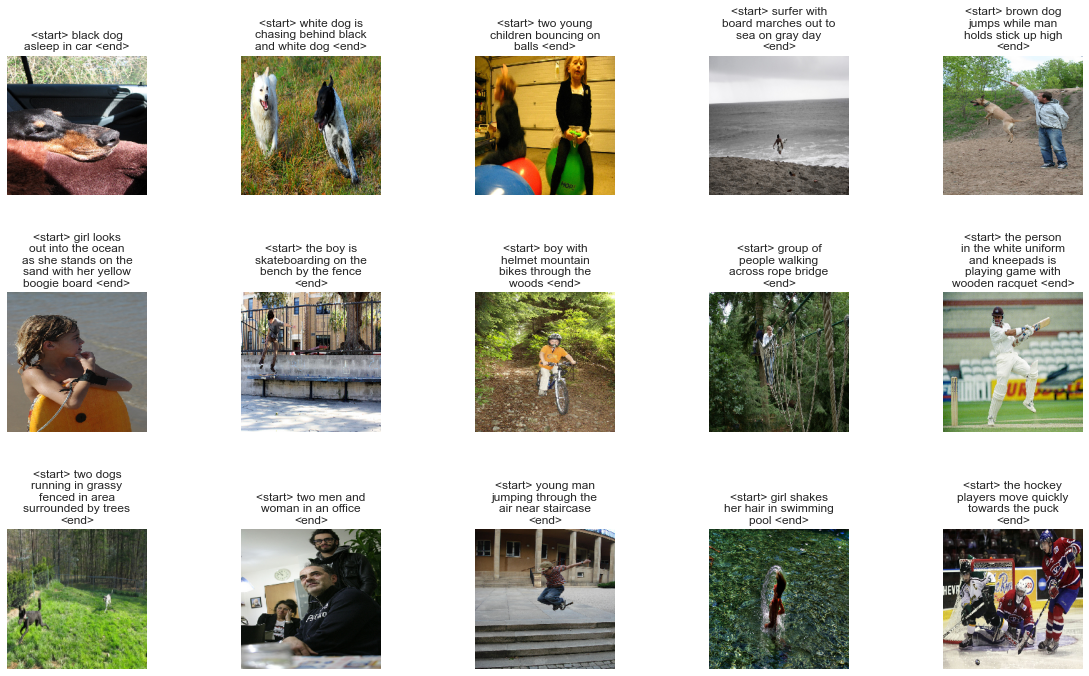

In [64]:
display_images(samples)


# 8.0  Evaluation metrics

in this part we are going to generate the captions predicted for the test set and run a series of evaluation metrics
Blue

### safe step -> here we can load the model trained

In [40]:
# caption_model = tf.keras.models.load_model('../2_cnn_lstm/model.h5')


## 8.1 generate the captions, both predicted and ground truth

In [272]:
def captions_actual_predicted(test=test, caption_model=caption_model, tokenizer=tokenizer, max_length=max_length, features_saved=features_saved):
    """generate the captions predicted in the test set and return the ground truth captions as well

    Args:
        test(dataframe): dataframe with the test information
        caption_model (model): model trained to predict captions
        tokenizer (model): tokenizer trained on the captions
        max_length (int): max length of the captions
        features_saved: feature map

    Returns:
        word: return two list with the captions generated and ground truth
    """
    actual_caption, predicted_caption = list(), list()
    images_test = test['image'].unique().tolist()

    for image_test in images_test:
        captions_test = test.caption[test['image'] == image_test]
        groundtruth_caption = [caption.split() for caption in captions_test]
        actual_caption.append(groundtruth_caption)

        y_ = predict_caption(caption_model, image_test,
                            tokenizer, max_length, features_saved)
        predicted_caption.append(y_.split())

    return actual_caption, predicted_caption

In [47]:
actual_caption, predicted_caption = captions_actual_predicted()


show one caption predicted

In [48]:
predicted_caption[0]


['<start>',
 'man',
 'in',
 'blue',
 'shirt',
 'is',
 'sitting',
 'on',
 'the',
 'ground',
 'in',
 'the',
 'air',
 '<end>']

# 8.2 Bleu Scores

BLEU-1. BLUE-2, Bilingual evaluation understudy represents the overall quality of the sentence that the model produces, it compares text segment with the ground truth values and return on average.

Now we can see an BLUE score on corpus example

In [34]:
import nltk
hypothesis = ['The', 'cat', 'sat', 'on', 'the', 'mat'] 
reference = ['This', 'is', 'cat', 'on' ,'the', 'mat']
references = [reference] # list of references for 1 sentence.
list_of_references = [references] # list of references for all sentences in corpus.
list_of_hypotheses = [hypothesis] # list of hypotheses that corresponds to list of references.
nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses, weights=(1.0, 0,0,0))

0.6666666666666666

## 8.2.1 Calculate the BLEU on corpus score for the caption generated on the test set

In [35]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu

print('Blue corpus')

print('Bleu1: %f ' % corpus_bleu(actual_caption, predicted_caption, weights=(1.0, 0,0,0)))
print('Bleu2: %f ' % corpus_bleu(actual_caption, predicted_caption, weights=(0, 1, 0, 0)))
print('Bleu3: %f ' % corpus_bleu(actual_caption, predicted_caption, weights=(0, 0, 1, 0)))
print('Bleu4: %f ' % corpus_bleu(actual_caption, predicted_caption, weights=(0.5, 0.5, 0.5, 0.5)))


Blue corpus


NameError: name 'actual_caption' is not defined

## 8.2.2 Calculate the BLEU on sentence score for the caption generated on the test set

In [276]:
def blue_sentence_score(actual_caption=actual_caption, predicted_caption=predicted_caption):
    """generate the BLEU sentence score on the captions passed

    Args:
        actual_caption (list, optional): _description_. Defaults to actual_caption.
        predicted_caption (list, optional): _description_. Defaults to predicted_caption.
    """
    bleu1_scores = []
    bleu2_scores = []
    bleu3_scores = []
    bleu4_scores = []

    for i in range(len(predicted_caption)):
        # bleu 1
        score_1 = sentence_bleu(actual_caption[i], predicted_caption[i], weights=(1.0, 0, 0, 0))
        bleu1_scores.append(score_1)
        # bleu 2
        score_2 = sentence_bleu(actual_caption[i], predicted_caption[i], weights=(0, 1, 0, 0))
        bleu2_scores.append(score_2)
        # bleu 3
        score_3 = sentence_bleu(actual_caption[i], predicted_caption[i], weights=(0, 0, 1, 0))
        bleu3_scores.append(score_3)
        # bleu 4
        score_4 = sentence_bleu(actual_caption[i], predicted_caption[i], weights=(0.5, 0.5, 0.5, 0.5))
        bleu4_scores.append(score_4)

    print('Bleu score sentence: ')
    print('Bleu_1 Score: {0}'.format(round(np.mean(bleu1_scores), 4)))
    print('Bleu_2 Score: {0}'.format(round(np.mean(bleu2_scores), 4)))
    print('Bleu_3 Score: {0}'.format(round(np.mean(bleu3_scores), 4)))
    print('Bleu_4 Score: {0}'.format(round(np.mean(bleu4_scores), 4)))


In [52]:
blue_sentence_score(actual_caption=actual_caption,
                    predicted_caption=predicted_caption)


Bleu score sentence: 
Bleu_1 Score: 0.5159
Bleu_2 Score: 0.1434
Bleu_3 Score: 0.0542
Bleu_4 Score: 0.0129


here we can see the BLEU score of one caption, in this case this is the evaluation of the first image caption generated in the test set

In [53]:
print('Bleu1: %f ' % sentence_bleu(actual_caption[0],
      predicted_caption[0], weights=(1.0, 0, 0, 0)))


Bleu1: 0.714286 


## 8.2.3 Meteor Score

‘Recall-Oriented Understudy for Gisting Evaluation’ will be used, it is used also to measure the quality of text summary and machine translation.[18]

now we can see an example of how meteor works

In [54]:
score = nltk.translate.meteor_score.meteor_score(
    ['<start>','the', 'cat', 'sat', 'on', 'the', 'mat'], 'the dog is on the mat')
print(np.mean(score))


0.33333333333333337


In [278]:
def meteor_metric_score(actual_caption=actual_caption, predicted_caption=predicted_caption):
    """generate meteor score in the captions tested

    Args:
        actual_caption (list, optional): _description_. Defaults to actual_caption.
        predicted_caption (list, optional): _description_. Defaults to predicted_caption.
    """
    actual_caption_meteor = [act_capt[0] for act_capt in actual_caption]
    predicted_caption_meteor = [' '.join(pre_capt) for pre_capt in predicted_caption]
    
    meteor_scores = []
    
    for i in range(len(actual_caption_meteor)):
        score = nltk.translate.meteor_score.meteor_score(
            actual_caption_meteor[i], predicted_caption_meteor[i])
        meteor_scores.append(score)

    print('Meteor Score: {0}'.format(round(np.mean(meteor_scores), 4)))


METEOR value in the test set

In [56]:
meteor_metric_score()

Meteor Score: 0.2813


# 9.0 Optimization process

in the optimization process we are going to repeat the steps 6, 7 and 8 in one cycle.

## 9.1 now we are going to use a bigger embedding representation from 256 to 512 in both
add a dense layer with 256 neuron after the lstm to reduce from 512 to 256 with regularization l2
the feature map and the word embedding

In [147]:
# now we are going to use the functional API to build our model with the encoder and decoder

# inputs holds info about the type and shape of the info preprocessed, inputs are also called symbolic tensors
input1 = Input(shape=(2048,), name='image_features') #feature shape VGG16 4096, shape ResNet50 2048
input2 = Input(shape=(max_length,), name='captions_preprocessed') #

img_features = Dense(512, activation='relu')(input1) #now we create a Dense layer with 256 neurones and pass the image features
img_features_reshaped = Reshape((1, 512), input_shape=(512,))(img_features) #now we reshape the image feature to 1, 256

sentence_features = Embedding(vocab_size, 512, mask_zero=False)(input2) #now we create a embedding layer with input dimension = vocabulary size and output dimension = 256, 
# and pass the captions 
merged = concatenate([img_features_reshaped, sentence_features],axis=1) #now we pass the 2 tensors of size 256 and merge on axis 1
sentence_features = LSTM(512)(merged) #it has 256 units, by default it hast activation == tanh, recurrent_activation == sigmoid, recurrent_dropout == 0,
# unroll is False, use_bias is True,  this are requirements to use GPU acceleration

x = Dropout(0.5)(sentence_features) #now we apply dropout to the ouput of the LSTM layer, we use 0.5 dropout, this is in order of prevent overfitting, it is only
# applyed during training
x = add([x, img_features])
# now we add the output of the img_features dense network

x = Dense(256, activation='relu', kernel_regularizer='l2')(x)  # also add a new layer to 256 to reduce the

x = Dense(128, activation='relu')(x) #apply a rely activaction and use 128 units
x = Dropout(0.5)(x) #now we apply dropout to the ouput after the dense layer, we use 0.5 dropout
output = Dense(vocab_size, activation='softmax')(x) # output the most likely sequence of words.

caption_model = Model(inputs=[input1,input2], outputs=output) #instatiate the model with 2 inputs and one output
optimizer = adam_v2.Adam() #use Adam optimizer to avoid local minima in multidimensional space
caption_model.compile(loss='categorical_crossentropy',optimizer=optimizer) # compile the model

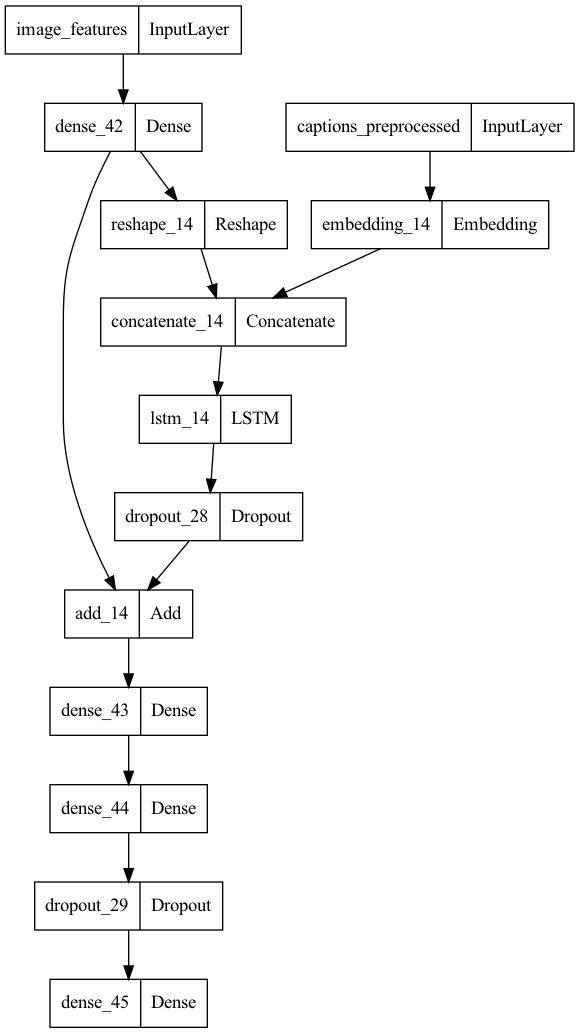

In [148]:
plot_model(caption_model)


In [149]:
caption_model.summary()


Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_features (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 dense_42 (Dense)               (None, 512)          1049088     ['image_features[0][0]']         
                                                                                                  
 captions_preprocessed (InputLa  [(None, 34)]        0           []                               
 yer)                                                                                             
                                                                                                  
 reshape_14 (Reshape)           (None, 1, 512)       0           ['dense_42[0][0]']        

In [151]:
# model callbacks to customize the behaviour of the model

# we are going to save the best model during training,
# we will use the validation loss to select the best model
model_name = "model_10_aug_512.h5"
checkpoint_path = '../2_cnn_lstm/model/'
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,  # save_weights_only=True,
                             verbose=1)

# if the model does not improve during 5 epochs
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=1,
                              restore_best_weights=True)

# reduce the learning rate when the model stop learning
# if the model does not improve during 3 epochs the learning rate is reduced
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00001)

# Let's enable visualization with tensorboard
tensorboard_callback = TensorBoard(log_dir="../2_cnn_lstm/logs/",
                                   histogram_freq=1,
                                   embeddings_freq=1)


# this is how to load the weights again

# Create a new model instance
# model = create_model()
# model.load_weights(checkpoint_path)

#  load all the model
# new_model = tf.keras.models.load_model('./model/model.h5')


when we call train the model fit(), we must select if we want to work
with augmented data or normal data.
the data augmented will be only the train part, so we use train_augmented_generator
and for both cases we will use validation data without augmentation

In [156]:
history = caption_model.fit(
    train_augmented_generator,
    epochs=10,  # they use 50 by default
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping,
               learning_rate_reduction, tensorboard_callback],
    verbose=0)



Epoch 00001: val_loss improved from inf to 4.65027, saving model to model_10_aug_512.h5

Epoch 00002: val_loss improved from 4.65027 to 4.27895, saving model to model_10_aug_512.h5

Epoch 00003: val_loss improved from 4.27895 to 4.13874, saving model to model_10_aug_512.h5

Epoch 00004: val_loss improved from 4.13874 to 4.05183, saving model to model_10_aug_512.h5

Epoch 00005: val_loss improved from 4.05183 to 3.98393, saving model to model_10_aug_512.h5

Epoch 00006: val_loss improved from 3.98393 to 3.95576, saving model to model_10_aug_512.h5

Epoch 00007: val_loss improved from 3.95576 to 3.91437, saving model to model_10_aug_512.h5

Epoch 00008: val_loss improved from 3.91437 to 3.89081, saving model to model_10_aug_512.h5

Epoch 00009: val_loss improved from 3.89081 to 3.88548, saving model to model_10_aug_512.h5

Epoch 00010: val_loss improved from 3.88548 to 3.87604, saving model to model_10_aug_512.h5


## Train - validation loss curve

now we can analyse the bias and variance of the model, after this optimization


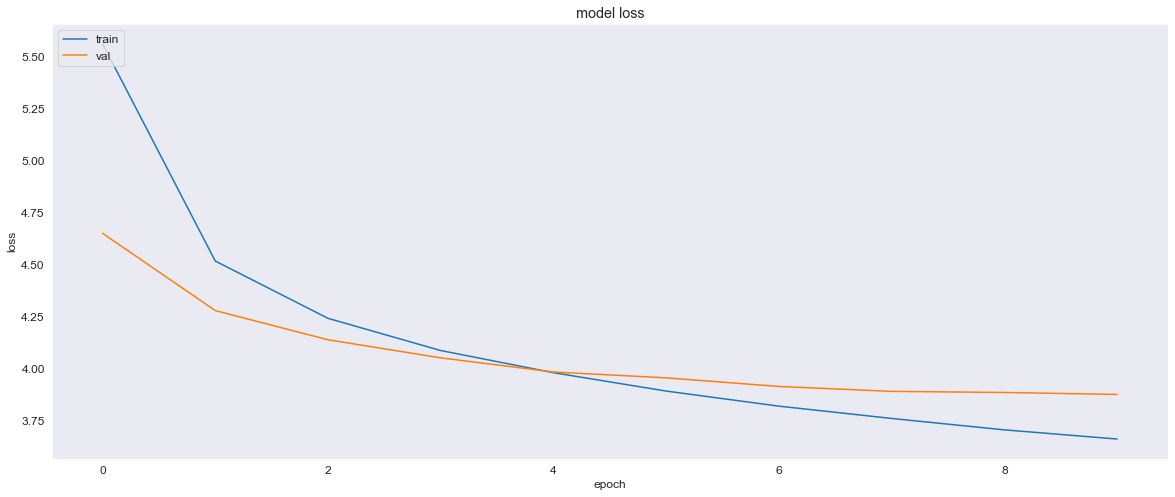

In [186]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Taking 15 Random Samples for Caption Prediction

In [183]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [184]:
for index, record in samples.iterrows():
    
    img = load_img(os.path.join(path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    # during inference we use the features_saved, those are the features without
    # augmentation in both cases when we work with and without augmentation
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features_saved)
    samples.loc[index,'caption'] = caption

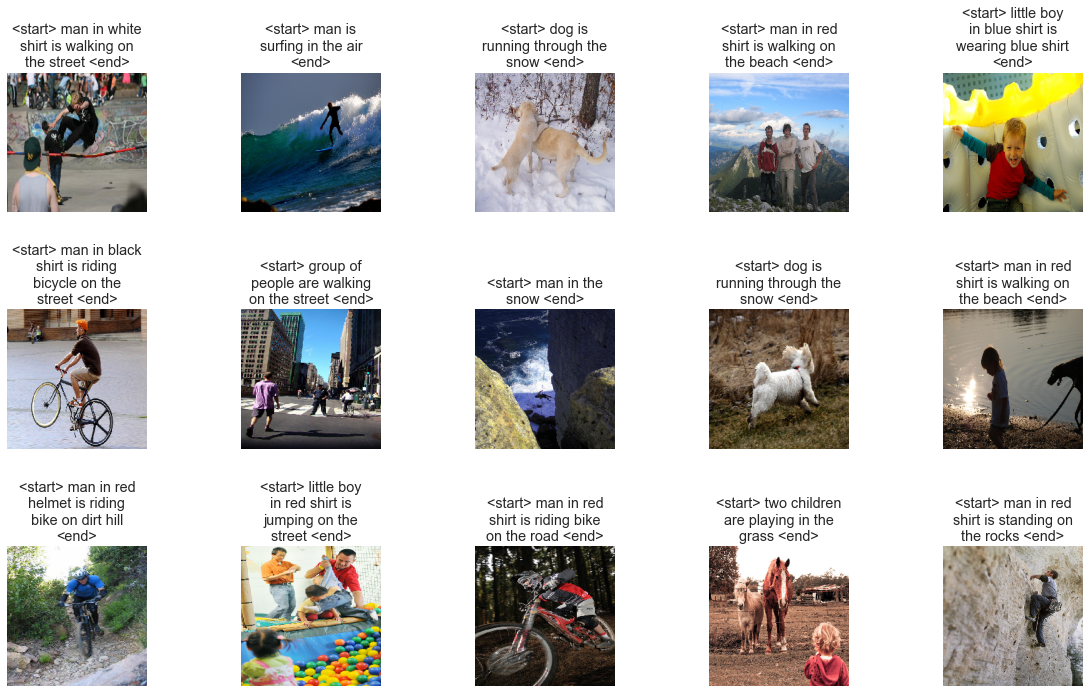

In [185]:
display_images(samples)


## Evaluation metric

# Blue

In [163]:
actual_caption, predicted_caption = captions_actual_predicted()


In [206]:
predicted_caption[0]


['<start>',
 'man',
 'in',
 'black',
 'shirt',
 'is',
 'sitting',
 'on',
 'the',
 'street',
 '<end>']

## Bleu Scores

## BLEU Corpus scores

In [173]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu

print('Blue corpus')

print('Bleu1: %f ' % corpus_bleu(actual_caption,
      predicted_caption, weights=(1.0, 0, 0, 0)))
print('Bleu2: %f ' % corpus_bleu(actual_caption,
      predicted_caption, weights=(0, 1, 0, 0)))
print('Bleu3: %f ' % corpus_bleu(actual_caption,
      predicted_caption, weights=(0, 0, 1, 0)))
print('Bleu4: %f ' % corpus_bleu(actual_caption,
      predicted_caption, weights=(0.5, 0.5, 0.5, 0.5)))


Blue corpus
Bleu1: 0.570286 
Bleu2: 0.189770 
Bleu3: 0.068892 
Bleu4: 0.012880 


## BLEU Sentence score

In [175]:
blue_sentence_score(actual_caption=actual_caption,
                    predicted_caption=predicted_caption)


Bleu score sentence: 
Bleu_1 Score: 0.5803
Bleu_2 Score: 0.2001
Bleu_3 Score: 0.0752
Bleu_4 Score: 0.0217


In [176]:
print('Bleu1: %f ' % sentence_bleu(actual_caption[0],
      predicted_caption[0], weights=(1.0, 0, 0, 0)))


Bleu1: 0.818182 


# Meteor Score

In [178]:
meteor_metric_score()


Meteor Score: 0.2801


## 9.2 Regularizing the LSTM using a recurrent drop mask

### now we are going to use a smaller embedding representation from 256 to 128 in both the embeddings and the LSTM

- add regularization l2 to the last dense layer to regularize high level featues
- add recurrent_dropout-0.2 to the LSTM to regularize the LSTM, this is an attempt to disrupt the propagation of the learning error through the time in the LSTM layer


In [194]:
# now we are going to use the functional API to build our model with the encoder and decoder

# inputs holds info about the type and shape of the info preprocessed, inputs are also called symbolic tensors
# feature shape VGG16 4096, shape ResNet50 2048
input1 = Input(shape=(2048,), name='image_features')
input2 = Input(shape=(max_length,), name='captions_preprocessed')

# now we create a Dense layer with 256 neurones and pass the image features
img_features = Dense(128, activation='relu')(input1)
img_features_reshaped = Reshape((1, 128), input_shape=(128,))(
    img_features)  # now we reshape the image feature to 1, 128

# now we create a embedding layer with input dimension = vocabulary size and output dimension = 256,
sentence_features = Embedding(vocab_size, 128, mask_zero=False)(input2)
# and pass the captions
# now we pass the 2 tensors of size 256 and merge on axis 1
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
# it has 256 units, by default it hast activation == tanh, recurrent_activation == sigmoid, recurrent_dropout == 0,
sentence_features = LSTM(128, recurrent_dropout=0.2)(merged)
# unroll is False, use_bias is True,  this are requirements to use GPU acceleration

# now we apply dropout to the ouput of the LSTM layer, we use 0.5 dropout, this is in order of prevent overfitting,
# and here we are regularizing the desnse layer
x = Dropout(0.5)(sentence_features)
# applyed during training
x = add([x, img_features])
# now we add the output of the img_features dense network

x = Dense(128, activation='relu', kernel_regularizer='l2')(
    x)  # also add a new layer to 256 to reduce the

# now we apply dropout to the ouput after the dense layer, we use 0.5 dropout
x = Dropout(0.5)(x)
# output the most likely sequence of words.
output = Dense(vocab_size, activation='softmax')(x)

# instatiate the model with 2 inputs and one output
caption_model = Model(inputs=[input1, input2], outputs=output)
# use Adam optimizer to avoid local minima in multidimensional space
optimizer = adam_v2.Adam()
caption_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer)  # compile the model


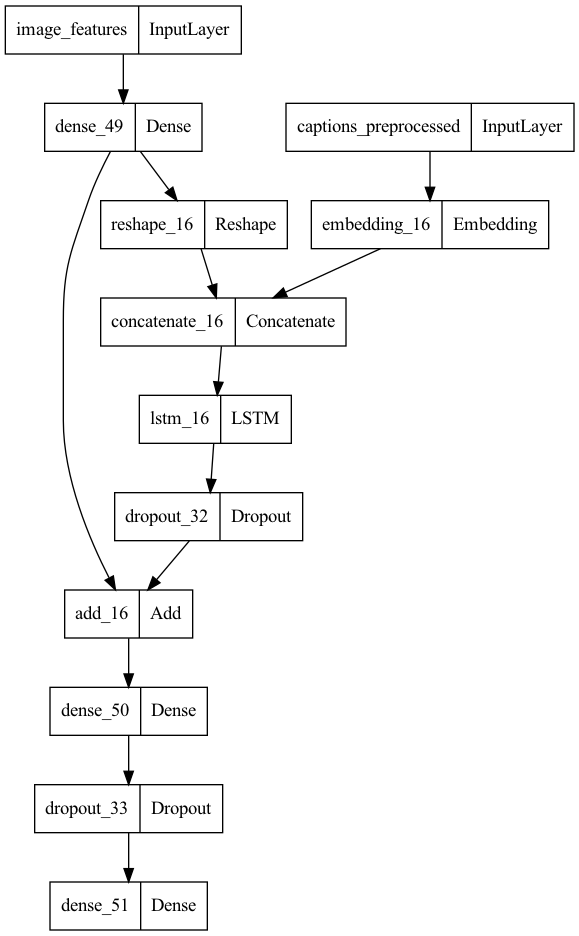

In [195]:
plot_model(caption_model)


In [196]:
caption_model.summary()


Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_features (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 dense_49 (Dense)               (None, 128)          262272      ['image_features[0][0]']         
                                                                                                  
 captions_preprocessed (InputLa  [(None, 34)]        0           []                               
 yer)                                                                                             
                                                                                                  
 reshape_16 (Reshape)           (None, 1, 128)       0           ['dense_49[0][0]']        

In [197]:
# model callbacks to customize the behaviour of the model

# we are going to save the best model during training,
# we will use the validation loss to select the best model
model_name = "model_10_aug_resnet_128.h5"
checkpoint_path = '../2_cnn_lstm/model/'
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,  # save_weights_only=True,
                             verbose=1)

# if the model does not improve during 5 epochs
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=1,
                              restore_best_weights=True)

# reduce the learning rate when the model stop learning
# if the model does not improve during 3 epochs the learning rate is reduced
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00001)

# Let's enable visualization with tensorboard
tensorboard_callback = TensorBoard(log_dir="../2_cnn_lstm/logs/",
                                   histogram_freq=1,
                                   embeddings_freq=1)


# this is how to load the weights again

# Create a new model instance
# model = create_model()
# model.load_weights(checkpoint_path)

#  load all the model
# new_model = tf.keras.models.load_model('./model/model.h5')


when we call train the model fit(), we must select if we want to work
with augmented data or normal data.
the data augmented will be only the train part, so we use train_augmented_generator
and for both cases we will use validation data without augmentation

In [198]:
history = caption_model.fit(
    train_augmented_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping,
               learning_rate_reduction, tensorboard_callback],
    verbose=2)


Epoch 1/10

Epoch 00001: val_loss improved from inf to 4.86437, saving model to model_10_aug_resnet_128.h5
442/442 - 5922s - loss: 5.7560 - val_loss: 4.8644 - lr: 0.0010 - 5922s/epoch - 13s/step
Epoch 2/10

Epoch 00002: val_loss improved from 4.86437 to 4.49963, saving model to model_10_aug_resnet_128.h5
442/442 - 5956s - loss: 4.7606 - val_loss: 4.4996 - lr: 0.0010 - 5956s/epoch - 13s/step
Epoch 3/10

Epoch 00003: val_loss improved from 4.49963 to 4.30471, saving model to model_10_aug_resnet_128.h5
442/442 - 5948s - loss: 4.4837 - val_loss: 4.3047 - lr: 0.0010 - 5948s/epoch - 13s/step
Epoch 4/10

Epoch 00004: val_loss improved from 4.30471 to 4.20623, saving model to model_10_aug_resnet_128.h5
442/442 - 5956s - loss: 4.3161 - val_loss: 4.2062 - lr: 0.0010 - 5956s/epoch - 13s/step
Epoch 5/10

Epoch 00005: val_loss improved from 4.20623 to 4.13198, saving model to model_10_aug_resnet_128.h5
442/442 - 5992s - loss: 4.2001 - val_loss: 4.1320 - lr: 0.0010 - 5992s/epoch - 14s/step
Epoch 6/1

## Train - validation loss curve

now we can analyse the bias and variance of the model, after this optimization

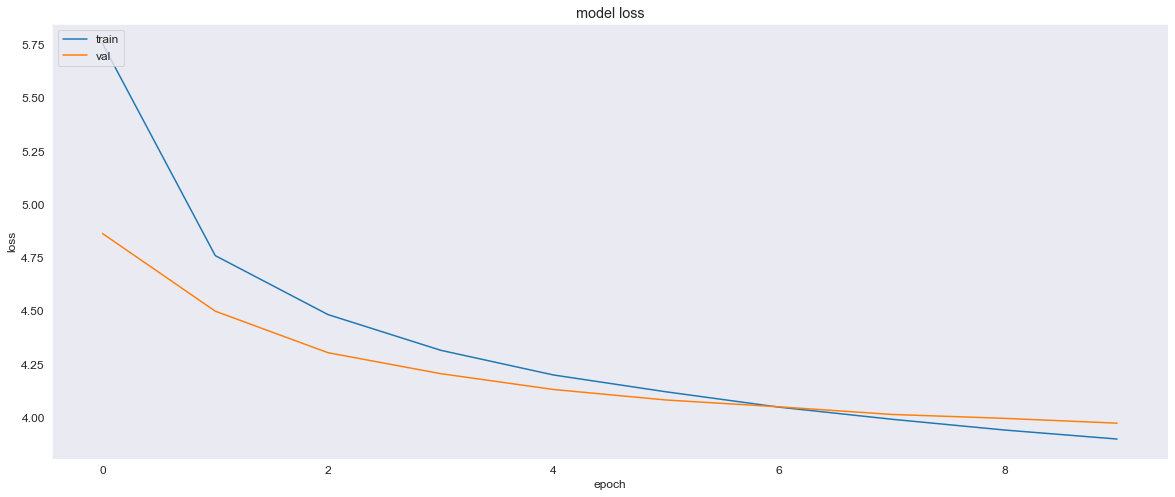

In [199]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Taking 15 Random Samples for Caption Prediction

In [200]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [201]:
for index, record in samples.iterrows():
    
    img = load_img(os.path.join(path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    # during inference we use the features_saved, those are the features without
    # augmentation in both cases when we work with and without augmentation
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features_saved)
    samples.loc[index,'caption'] = caption

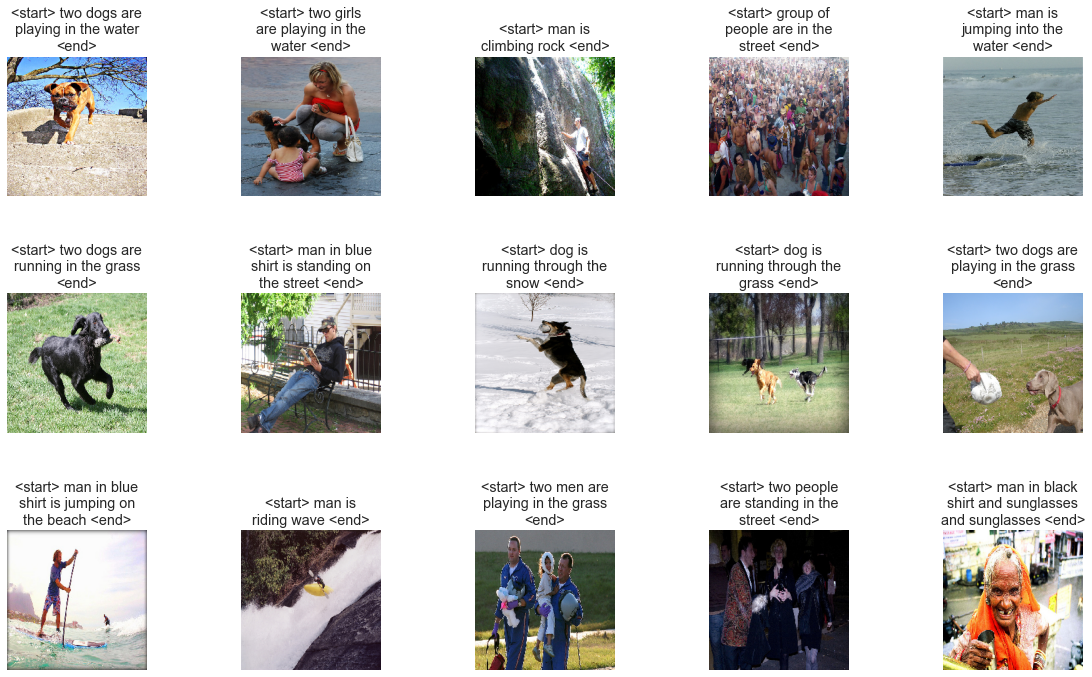

In [202]:
display_images(samples)


## Evaluation metric


In [209]:
actual_caption, predicted_caption = captions_actual_predicted()


In [210]:
predicted_caption[0]


['<start>', 'man', 'is', 'sitting', 'on', 'the', 'street', '<end>']

## Bleu Corpus Scores

In [211]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu

print('Blue corpus')

print('Bleu1: %f ' % corpus_bleu(actual_caption,
      predicted_caption, weights=(1.0, 0, 0, 0)))
print('Bleu2: %f ' % corpus_bleu(actual_caption,
      predicted_caption, weights=(0, 1, 0, 0)))
print('Bleu3: %f ' % corpus_bleu(actual_caption,
      predicted_caption, weights=(0, 0, 1, 0)))
print('Bleu4: %f ' % corpus_bleu(actual_caption,
      predicted_caption, weights=(0.5, 0.5, 0.5, 0.5)))


Blue corpus
Bleu1: 0.592527 
Bleu2: 0.211584 
Bleu3: 0.079473 
Bleu4: 0.015761 


## BLEU Sentence score

In [212]:
blue_sentence_score(actual_caption=actual_caption,
                    predicted_caption=predicted_caption)


Bleu score sentence: 
Bleu_1 Score: 0.6008
Bleu_2 Score: 0.2207
Bleu_3 Score: 0.0846
Bleu_4 Score: 0.0243


In [213]:
print('Bleu1: %f ' % sentence_bleu(actual_caption[0],
      predicted_caption[0], weights=(1.0, 0, 0, 0)))


Bleu1: 0.875000 


# Meteor Score

In [216]:
meteor_metric_score()


Meteor Score: 0.3061


## 9.3 Loading the model and training it for 10 more epochs

In [218]:
# model callbacks to customize the behaviour of the model

# we are going to save the best model during training,
# we will use the validation loss to select the best model
model_name = "model_20_aug_resnet_128.h5"
checkpoint_path = '../2_cnn_lstm/model/'
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,  # save_weights_only=True,
                             verbose=1)

# if the model does not improve during 5 epochs
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=1,
                              restore_best_weights=True)

# reduce the learning rate when the model stop learning
# if the model does not improve during 3 epochs the learning rate is reduced
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00001)

# Let's enable visualization with tensorboard
tensorboard_callback = TensorBoard(log_dir="../2_cnn_lstm/logs/",
                                   histogram_freq=1,
                                   embeddings_freq=1)


# this is how to load the weights again

# Create a new model instance
# model = create_model()
# model.load_weights(checkpoint_path)

#  load all the model
caption_model = tf.keras.models.load_model('./model_10_aug_resnet_128.h5')


In [219]:
history = caption_model.fit(
    train_augmented_generator,
    epochs=10,  # they use 50 by default
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping,
               learning_rate_reduction, tensorboard_callback],
    verbose=2)


Epoch 1/10

Epoch 00001: val_loss improved from inf to 3.95427, saving model to model_20_aug_resnet_128.h5
442/442 - 5500s - loss: 3.8622 - val_loss: 3.9543 - lr: 0.0010 - 5500s/epoch - 12s/step
Epoch 2/10

Epoch 00002: val_loss did not improve from 3.95427
442/442 - 6000s - loss: 3.8304 - val_loss: 3.9626 - lr: 0.0010 - 6000s/epoch - 14s/step
Epoch 3/10

Epoch 00003: val_loss improved from 3.95427 to 3.93710, saving model to model_20_aug_resnet_128.h5
442/442 - 5698s - loss: 3.7994 - val_loss: 3.9371 - lr: 0.0010 - 5698s/epoch - 13s/step
Epoch 4/10

Epoch 00004: val_loss improved from 3.93710 to 3.92801, saving model to model_20_aug_resnet_128.h5
442/442 - 5963s - loss: 3.7745 - val_loss: 3.9280 - lr: 0.0010 - 5963s/epoch - 13s/step
Epoch 5/10

Epoch 00005: val_loss improved from 3.92801 to 3.92199, saving model to model_20_aug_resnet_128.h5
442/442 - 5867s - loss: 3.7468 - val_loss: 3.9220 - lr: 0.0010 - 5867s/epoch - 13s/step
Epoch 6/10

Epoch 00006: val_loss improved from 3.92199 t

## Train - validation loss curve

now we can analyse the bias and variance of the model, after this optimization

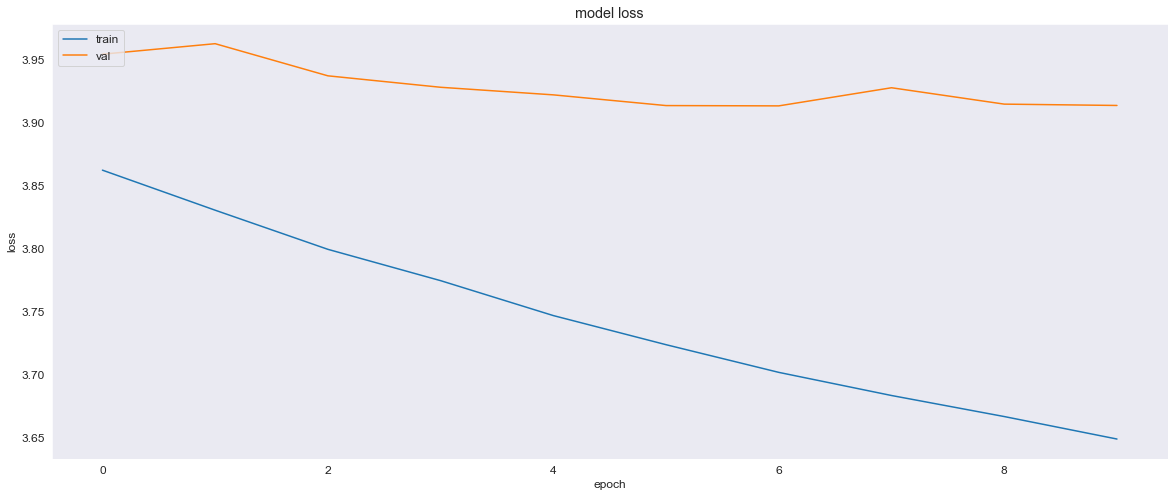

In [220]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Taking 15 Random Samples for Caption Prediction

In [250]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [251]:
for index, record in samples.iterrows():
    
    img = load_img(os.path.join(path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    # during inference we use the features_saved, those are the features without
    # augmentation in both cases when we work with and without augmentation
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features_saved)
    samples.loc[index,'caption'] = caption

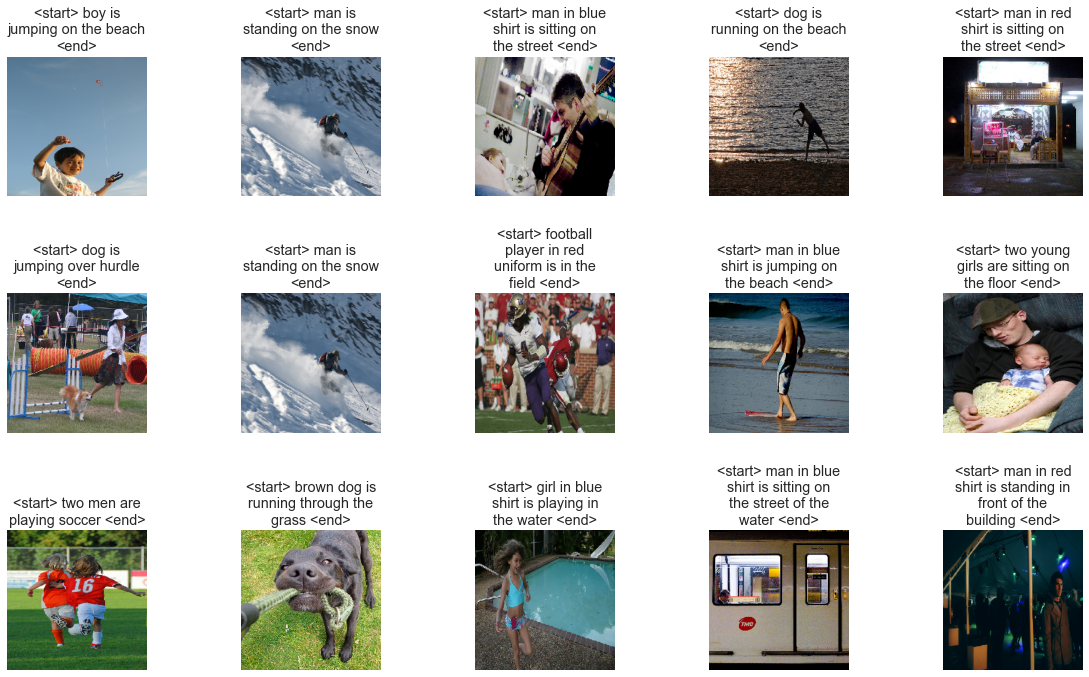

In [252]:
display_images(samples)


## Evaluation metric


In [225]:
actual_caption, predicted_caption = captions_actual_predicted()


In [255]:
predicted_caption[0]


['<start>',
 'man',
 'is',
 'sitting',
 'on',
 'the',
 'sidewalk',
 'of',
 'the',
 'wall',
 '<end>']

# BLEU Corpus Scores

In [227]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu

print('Blue corpus')

print('Bleu1: %f ' % corpus_bleu(actual_caption,
      predicted_caption, weights=(1.0, 0, 0, 0)))
print('Bleu2: %f ' % corpus_bleu(actual_caption,
      predicted_caption, weights=(0, 1, 0, 0)))
print('Bleu3: %f ' % corpus_bleu(actual_caption,
      predicted_caption, weights=(0, 0, 1, 0)))
print('Bleu4: %f ' % corpus_bleu(actual_caption,
      predicted_caption, weights=(0.5, 0.5, 0.5, 0.5)))


Blue corpus
Bleu1: 0.582897 
Bleu2: 0.205208 
Bleu3: 0.080418 
Bleu4: 0.016247 


## BLEU Sentence score

In [228]:
blue_sentence_score(actual_caption=actual_caption,
                    predicted_caption=predicted_caption)


Bleu score sentence: 
Bleu_1 Score: 0.5917
Bleu_2 Score: 0.2162
Bleu_3 Score: 0.0876
Bleu_4 Score: 0.0271


In [229]:
print('Bleu1: %f ' % sentence_bleu(actual_caption[0],
      predicted_caption[0], weights=(1.0, 0, 0, 0)))


Bleu1: 0.727273 


# Meteor Score

In [232]:
meteor_metric_score()


Meteor Score: 0.2967


## 9.4 Regularizing the LSTM using a recurrent drop mask

### now we are going to use an embedding representation of 256 in both the embeddings and the LSTM

- add regularization l2 to the last dense layer to regularize high level featues
- add recurrent_dropout-0.2 to the LSTM to regularize the LSTM, this is an attempt to disrupt the propagation of the learning error through the time in the LSTM layer


In [257]:
# now we are going to use the functional API to build our model with the encoder and decoder

# inputs holds info about the type and shape of the info preprocessed, inputs are also called symbolic tensors
# feature shape VGG16 4096, shape ResNet50 2048
input1 = Input(shape=(2048,), name='image_features')
input2 = Input(shape=(max_length,), name='captions_preprocessed')

# now we create a Dense layer with 256 neurones and pass the image features
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(
    img_features)  # now we reshape the image feature to 1, 256

# now we create a embedding layer with input dimension = vocabulary size and output dimension = 256,
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
# and pass the captions
# now we pass the 2 tensors of size 256 and merge on axis 1
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
# it has 256 units, by default it hast activation == tanh, recurrent_activation == sigmoid, recurrent_dropout == 0,
sentence_features = LSTM(256, recurrent_dropout=0.2)(merged)
# unroll is False, use_bias is True,  this are requirements to use GPU acceleration

# now we apply dropout to the ouput of the LSTM layer, we use 0.5 dropout, this is in order of prevent overfitting,
# and here we are regularizing the desnse layer
x = Dropout(0.5)(sentence_features)
# here we use a residual connection, same concept used in ResNet50 architecture
x = add([x, img_features])
# now we add the output of the img_features dense network
x = Dense(128, activation='relu', kernel_regularizer='l2')(
    x)  # also add a new layer to 256 to reduce the

# now we apply dropout to the ouput after the dense layer, we use 0.5 dropout
x = Dropout(0.5)(x)
# output the most likely sequence of words.
output = Dense(vocab_size, activation='softmax')(x)

# instatiate the model with 2 inputs and one output
caption_model = Model(inputs=[input1, input2], outputs=output)
# use Adam optimizer to avoid local minima in multidimensional space
optimizer = adam_v2.Adam()
caption_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer)  # compile the model


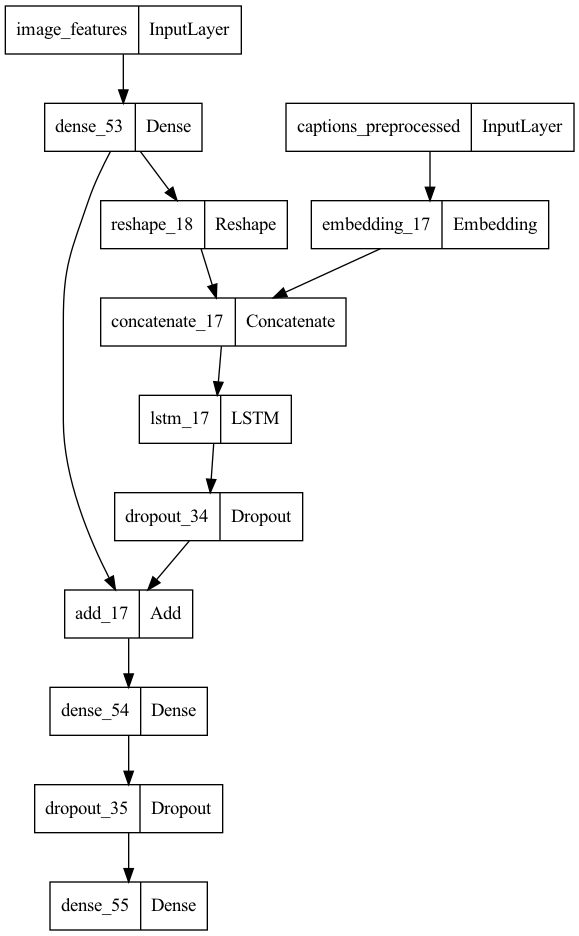

In [258]:
plot_model(caption_model)


In [259]:
caption_model.summary()


Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_features (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 dense_53 (Dense)               (None, 256)          524544      ['image_features[0][0]']         
                                                                                                  
 captions_preprocessed (InputLa  [(None, 34)]        0           []                               
 yer)                                                                                             
                                                                                                  
 reshape_18 (Reshape)           (None, 1, 256)       0           ['dense_53[0][0]']        

In [260]:
# model callbacks to customize the behaviour of the model

# we are going to save the best model during training,
# we will use the validation loss to select the best model
model_name = "model_10_aug_resnet_256.h5"
checkpoint_path = '../2_cnn_lstm/model/'
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,  # save_weights_only=True,
                             verbose=1)

# if the model does not improve during 5 epochs
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=1,
                              restore_best_weights=True)

# reduce the learning rate when the model stop learning
# if the model does not improve during 3 epochs the learning rate is reduced
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00001)

# Let's enable visualization with tensorboard
tensorboard_callback = TensorBoard(log_dir="../2_cnn_lstm/logs/",
                                   histogram_freq=1,
                                   embeddings_freq=1)


# this is how to load the weights again

# Create a new model instance
# model = create_model()
# model.load_weights(checkpoint_path)

#  load all the model
# new_model = tf.keras.models.load_model('./model/model.h5')


when we call train the model fit(), we must select if we want to work
with augmented data or normal data.
the data augmented will be only the train part, so we use train_augmented_generator
and for both cases we will use validation data without augmentation

In [261]:
history = caption_model.fit(
    train_augmented_generator,
    epochs=10, 
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping,
               learning_rate_reduction, tensorboard_callback],
    verbose=2)


Epoch 1/10

Epoch 00001: val_loss improved from inf to 4.76596, saving model to model_10_aug_resnet_256.h5
442/442 - 5476s - loss: 5.6571 - val_loss: 4.7660 - lr: 0.0010 - 5476s/epoch - 12s/step
Epoch 2/10

Epoch 00002: val_loss improved from 4.76596 to 4.42424, saving model to model_10_aug_resnet_256.h5
442/442 - 5221s - loss: 4.6692 - val_loss: 4.4242 - lr: 0.0010 - 5221s/epoch - 12s/step
Epoch 3/10

Epoch 00003: val_loss improved from 4.42424 to 4.25864, saving model to model_10_aug_resnet_256.h5
442/442 - 5772s - loss: 4.4028 - val_loss: 4.2586 - lr: 0.0010 - 5772s/epoch - 13s/step
Epoch 4/10

Epoch 00004: val_loss improved from 4.25864 to 4.14901, saving model to model_10_aug_resnet_256.h5
442/442 - 5740s - loss: 4.2472 - val_loss: 4.1490 - lr: 0.0010 - 5740s/epoch - 13s/step
Epoch 5/10

Epoch 00005: val_loss improved from 4.14901 to 4.08822, saving model to model_10_aug_resnet_256.h5
442/442 - 5668s - loss: 4.1368 - val_loss: 4.0882 - lr: 0.0010 - 5668s/epoch - 13s/step
Epoch 6/1

## Train - validation loss curve

now we can analyse the bias and variance of the model, after this optimization

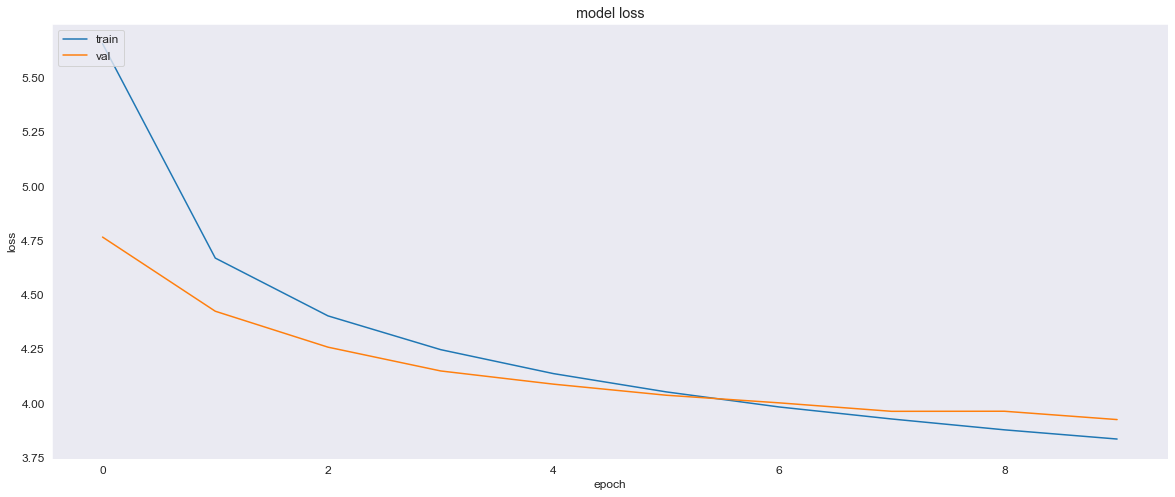

In [262]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Taking 15 Random Samples for Caption Prediction

In [269]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [270]:
for index, record in samples.iterrows():
    
    img = load_img(os.path.join(path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    # during inference we use the features_saved, those are the features without
    # augmentation in both cases when we work with and without augmentation
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features_saved)
    samples.loc[index,'caption'] = caption

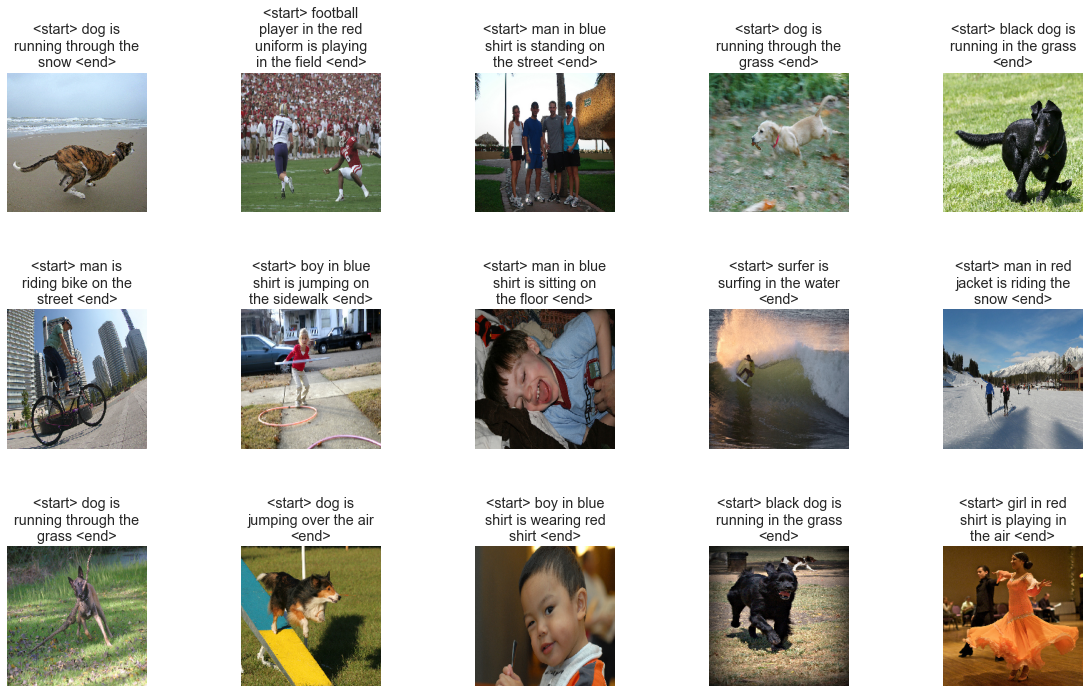

In [271]:
display_images(samples)


## Evaluation metric

In [273]:
actual_caption, predicted_caption = captions_actual_predicted()


In [274]:
predicted_caption[0]


['<start>',
 'man',
 'in',
 'blue',
 'shirt',
 'is',
 'standing',
 'on',
 'the',
 'street',
 '<end>']

# BLEU Corpus Scores

In [275]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu

print('Blue corpus')

print('Bleu1: %f ' % corpus_bleu(actual_caption,
      predicted_caption, weights=(1.0, 0, 0, 0)))
print('Bleu2: %f ' % corpus_bleu(actual_caption,
      predicted_caption, weights=(0, 1, 0, 0)))
print('Bleu3: %f ' % corpus_bleu(actual_caption,
      predicted_caption, weights=(0, 0, 1, 0)))
print('Bleu4: %f ' % corpus_bleu(actual_caption,
      predicted_caption, weights=(0.5, 0.5, 0.5, 0.5)))


Blue corpus
Bleu1: 0.517385 
Bleu2: 0.183064 
Bleu3: 0.065080 
Bleu4: 0.011404 


## BLEU Sentence score

In [277]:
blue_sentence_score(actual_caption=actual_caption,
                    predicted_caption=predicted_caption)


Bleu score sentence: 
Bleu_1 Score: 0.578
Bleu_2 Score: 0.2156
Bleu_3 Score: 0.0809
Bleu_4 Score: 0.0261


# Meteor Score

In [279]:
meteor_metric_score()


Meteor Score: 0.2729


# 10.0 Conclusions



In this project, we have analyzed how to generate automatic image captions that can be used to generate a context for visually impaired people using deep learning techniques, more specifically the encoder-decoder architecture with CNN and LSTM. 

This project developed an automatic image caption generation using deep learning, specifically using the encoder-decoder architecture. Two different pre-trained convolutional neural networks were used to extract the feature map from the images, one was the VGG16 and the other was ResNet50. In this project we use the concept of transfer learning to use the weights of a pre-trained neural network on a big dataset, specifically, we used the weights from the training on the ImageNet dataset. We also use embeddings to represent the ground truth caption in a lower dimensional space, we used the functional API to develop the main neural network that takes 2 inputs and returns one output, additionally, callbacks were used to save the best model, for early stopping to avoid spending resources and time just overfitting the model, for plateau optimization, in addition, it was used data augmentation during each epoch to help the model to learn a widen feature map to generate the captions and retard the overfitting process, finally, the object hallucination problem was identified and an additional approach was carryout to decrease that problem in the model. 

Comparing the CNN architectures, we found that the models with ResNet50 had a better performance than the model using VGG16, here is important to point out that the ResNet50 uses residual connections that help to prevent vanishing gradient and preserve information more efficiently than the VGG16. Additionally, the feature map from the ResNet50 has fewer dimensions than the feature map from VGG16 which also will have a direct impact on the number of parameters to be trained by the final model, which is related to the time needed for each epoch. 

In this project, we tried different model architectures, different regularization parameters, different optimizers for multidimensional plateaus, and different algorithms with adaptative learning rates to produce the final model architecture. We found that when we are dealing with architecture model decisions, we always can make use of Occam’s Razor principle and choose the most simple and efficient hypothesis. Using this principle, we selected the number of layers and neurons in our model as well as it was the base for each optimization decision. In this kind of project, we must analyze each decision because it will take around 2 hours to get the information of one epoch and more than 20 hours for 10 epochs run and be able to compare 2 different models.  

Analyzing the long time needed by the model to be trained we found that using data augmentation during each epoch is one of the main causes of those times, this is because at each epoch the model generated a completely new training set of images, with the main objective of obtaining a richer feature map that would simulate the pictures taken by a visually impaired person. The second most important factor we considered impacted the time was the fact that we used a recurrent neural network, more specifically the LSTM layer as a decoder to generate the caption sequence, the recurrent neural networks have a sequential processing nature, they need to generate a sequence of hidden steps in the function of previous inputs and the current input, this behavior cannot be parallelized and increase the complexity per layer up to O(n * d^2), where n is the sequence length and d is the representation dimension. When we cannot parallelize an operation we lose the advantage of training on GPU, this means that even though we did the training on CPU, we might have a similar time training on GPU.

The model was evaluated using the BLEU sentence score, METEOR and subjective analysis of the captions was also carryout, we achieved better results than the baseline paper in BLEU1 and we found that the captions generated by the model bring value to expand the context of a visually impaired person, however, the model presented object hallucination problems. When we as humans describe one image, we could focus our attention on some parts of the image and not describe all the objects in it, however, we do not add objects to the description that is not present in the image, taking that approach, we did an optimization to reduce object hallucination. There were two options for reducing it, one was to improve the feature map, however, because we were using knowledge transfer with pre-trained CNN one option would be to limit the scope of the project and fine-tune on a specific set of labels, but taking into account the user, we did not want to limit the scope of the project, therefore, the second option was to reduce the overfitting, in this option we want to increase the bias and variance of the model to generalize better and do not force the model to make precise predictions, after trying different model architectures as parameters we achieve a model that reduce object hallucination, nevertheless, the object hallucination analysis was subjective, manually reading the captions. This is a part to improve and carry out automatic object hallucination metrics.

It is important to point out that the state of the art in terms of image caption generation uses attention mechanisms with transformer architectures. They can use attention in the encoder part to extract information from the image by taking the low-level representation from a CNN and focusing on important parts of an image and it also uses attention in the decoder to replace the LSTM layer by an attention mechanism to model the dependencies of the inputs and the output word sequence. The transformer used in the decoder also removes the sequence dependency and makes the process parallelizable which is more efficient, and it also requires less training time. This project will be rebuilt using attention as a personal project.

Finally, I would like to point out that in this project aspects such as optimization, and object hallucination was considered, and those aspects were beyond the literature review.

# 11 References

References

1)	National Eye Institute (2019). How the Eyes Work | National Eye Institute. [online] www.nei.nih.gov. Available at: https://www.nei.nih.gov/learn-about-eye-health/healthy-vision/how-eyes-work#:~:text=When%20light%20hits%20the%20retina.
2)	Penn Today. (n.d.). Decoding how the brain accurately depicts ever-changing visual landscapes. [online] Available at: https://penntoday.upenn.edu/news/decoding-how-brain-accurately-depicts-ever-changing-visual-landscapes#:~:text=Experiments%20using%20static%20stimuli%2C%20such 
3)	Do blind people really experience complete darkness? (2015). BBC News. [online] 25 Feb. Available at: https://www.bbc.com/news/blogs-ouch-31487662
4)	Health Policy Institute. (n.d.). Visual Impairments. [online] Available at: https://hpi.georgetown.edu/visual/#:~:text=Almost%2020%20million%20Americans%20%E2%80%94%208
5)	www.ibm.com. (n.d.). What is Computer Vision? | IBM. [online] Available at: https://www.ibm.com/topics/computer-vision#:~:text=Computer%20vision%20is%20a%20field
6)	Sudhakar, J., Iyer, V.V. and Sharmila, S.T. (2022). Image Caption Generation using Deep Neural Networks. 2022 International Conference for Advancement in Technology (ICONAT). doi:10.1109/iconat53423.2022.9726074.
7)	Amritkar, C. and Jabade, V. (2018). Image Caption Generation Using Deep Learning Technique. [online] IEEE Xplore. doi:10.1109/ICCUBEA.2018.8697360.
8)	Ghandi, T., Pourreza, H. and Mahyar, H. (2022). Deep Learning Approaches on Image Captioning: A Review. arXiv:2201.12944 [cs]. [online] Available at: https://arxiv.org/abs/2201.12944.
9)	Wikipedia Contributors (2019). Convolutional neural network. [online] Wikipedia. Available at: https://en.wikipedia.org/wiki/Convolutional_neural_network.
10)	Wikipedia Contributors (2018). Recurrent neural network. [online] Wikipedia. Available at: https://en.wikipedia.org/wiki/Recurrent_neural_network.
11)	NVIDIA Developer Blog. (2015). Deep Learning in a Nutshell: Core Concepts. [online] Available at: https://developer.nvidia.com/blog/deep-learning-nutshell-core-concepts/.
12)	Datagen. (n.d.). ResNet-50: The Basics and a Quick Tutorial. [online] Available at: https://datagen.tech/guides/computer-vision/resnet-50/.
13)	Waghmare, P., Shinde, S. and Katti, J. (2022). Image Captioning using Neural Network Model. 2022 International Conference on Smart Technologies and Systems for Next Generation Computing (ICSTSN). doi:10.1109/icstsn53084.2022.9761320.
14)	Atliha, V. and Sesok, D. (2020). Comparison of VGG and ResNet used as Encoders for Image Captioning. 2020 IEEE Open Conference of Electrical, Electronic and Information Sciences (eStream). doi:10.1109/estream50540.2020.9108880.
15)	 Fleet, D., Pajdla, T., Bernt Schiele, Tinne Tuytelaars and Springerlink (Online Service (2014). Computer Vision -- ECCV 2014 : 13th European Conference, Zurich, Switzerland, September 6-12, 2014, Proceedings, Part V. Cham: Springer International Publishing.
16)	Aditya Kumar Yadav, Prakash.J. (2021). Image Captioning Using R-CNN & LSTM Deep Learning Model. International Journal of Innovative Science and Research Technology
17)	IBM Research Blog. (2021). Image captioning as an assistive technology. [online] Available at: https://research.ibm.com/blog/image-captioning-assistive-technology
18)	Wikipedia Contributors (2019). ROUGE (metric). [online] Wikipedia. Available at: https://en.wikipedia.org/wiki/ROUGE_(metric).
19)	Wikipedia Contributors (2019). ImageNet. [online] Wikipedia. Available at: https://en.wikipedia.org/wiki/ImageNet.
20)	Wikipedia Contributors (2019). Transfer learning. [online] Wikipedia. Available at: https://en.wikipedia.org/wiki/Transfer_learning.
21)	Amritkar, C. and Jabade, V. (2018). Image Caption Generation Using Deep Learning Technique. [online] IEEE Xplore. doi:https://doi.org/10.1109/ICCUBEA.2018.8697360.
22)	www.kaggle.com. (n.d.). Flickr 8k Dataset. [online] Available at: https://www.kaggle.com/datasets/adityajn105/flickr8k.
23)	kaggle.com. (n.d.). VGGNet-16 Architecture: A Complete Guide. [online] Available at: https://www.kaggle.com/code/blurredmachine/vggnet-16-architecture-a-complete-guide.
24)	Shafiq, M. and Gu, Z. (2022). Deep Residual Learning for Image Recognition: A Survey. Applied Sciences, 12(18), p.8972. doi:https://doi.org/10.3390/app12188972.
25)	Wikipedia Contributors (2018). Long short-term memory. [online] Wikipedia. Available at: https://en.wikipedia.org/wiki/Long_short-term_memory.
26)	Wikipedia Contributors (2019). BLEU. [online] Wikipedia. Available at: https://en.wikipedia.org/wiki/BLEU.
27)	 Vinyals, O., Toshev, A., Bengio, S., & Erhan, D. (2014). Show and Tell: A Neural Image Caption Generator. ArXiv. /abs/1411.4555
28)	Rohrbach, A., Hendricks, L. A., Burns, K., Darrell, T., & Saenko, K. (2018). Object Hallucination in Image Captioning. ArXiv. /abs/1809.02156

